**Generating Counterfactual Explanations using DICE ML**

The code has two parts

Notebook Adapted from Work by Fares Sayah  on kaggle

Source: https://www.kaggle.com/code/faressayah/decision-trees-random-forest-for-beginners/notebook

In [ ]:
# My dataset is stored in my google drive. You can do the same or choose an alternative method

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# install dice-ml
!pip install dice-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 72.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
# Scale numerical columns if needed
from sklearn.preprocessing import StandardScaler
# import DiCE
import dice_ml
from dice_ml.utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot
import joblib

In [ ]:
# In the next few steps, I read the dataset, prepare it and then train a Decision Tree and Random Forest classifers. We then generate SHAP explanations for the RF classifier.


df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/EmployeeAttritionUpdated.csv")
attrition = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/EmployeeAttritionUpdated.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,OverTime,PercentSalaryHike,PerformanceRating,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,Yes,11,3,80,8,0,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,No,23,4,80,10,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,Yes,15,3,80,7,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,Yes,11,3,80,8,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,No,12,3,80,6,3,2,2,2,2


In [ ]:
# Define a dictionary for the target mapping
target_map = {'Yes': 1, 'No': 0}

# Use the pandas apply method to numerically encode our attrition target variable
attrition["Attrition_numerical"] = attrition["Attrition"].apply(lambda x: target_map[x])

# Drop the Attrition_numerical column from attrition dataset first - Don't want to include that
attrition = attrition.drop(['Attrition_numerical'], axis=1)

# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.items():  # Use items() instead of iteritems()
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attrition.columns.difference(categorical)

# Output the lists for verification
print("Categorical columns:", categorical)
print("Numerical columns:", numerical)


Categorical columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numerical columns: Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'StandardHours',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


In [ ]:
# Store the categorical data in a dataframe called attrition_cat
attrition_cat = attrition[categorical]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column
attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [ ]:

scaler = StandardScaler()
attrition_num_scaled = pd.DataFrame(scaler.fit_transform(attrition[numerical]), columns=numerical)
attrition_num = attrition[numerical]
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1)
attrition_final_labels =  pd.concat([attrition_num, attrition_cat, attrition["Attrition"]], axis=1)
attrition_final_labels.head()


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,1,0,0,0,1,0,1,Yes
1,49,279,8,1,3,61,2,2,2,5130,...,0,1,0,0,0,1,0,1,0,No
2,37,1373,2,2,4,92,2,1,3,2090,...,0,0,0,0,0,0,1,0,1,Yes
3,33,1392,3,4,4,56,3,1,3,2909,...,0,1,0,0,0,1,0,0,1,No
4,27,591,2,1,1,40,3,1,2,3468,...,0,0,0,0,0,1,0,1,0,No


In [ ]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = attrition["Attrition"].apply(lambda x: target_map[x])
target.head(3)

,Attrition
0,1
1,0
2,1


<Axes: xlabel='Attrition', ylabel='count'>

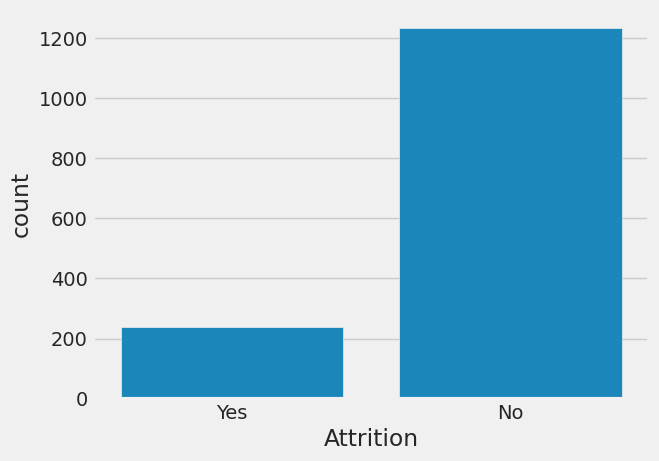

In [ ]:
sns.countplot(x='Attrition', data=attrition)


In [ ]:



# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_test = train_test_split(attrition_final,
                                                         target,
                                                         train_size= 0.80,
                                                         random_state=0);
#train, test, target_train, target_val = StratifiedShuffleSplit(attrition_final, target, random_state=0);

In [ ]:
from collections import Counter

# Initialize the SMOTE oversampler
oversampler = SMOTE(random_state=0)

# Perform oversampling on the training data
smote_train, smote_target = oversampler.fit_resample(train, target_train)

# Check the new class distribution

print("Class distribution after SMOTE:", Counter(smote_target))


Class distribution after SMOTE: Counter({0: 988, 1: 988})


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(smote_train, smote_target)

print_score(tree_clf, smote_train, smote_target, test, target_test, train=True)
print_score(tree_clf, smote_train, smote_target, test, target_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    988.0  988.0       1.0     1976.0        1976.0
_______________________________________________
Confusion Matrix: 
 [[988   0]
 [  0 988]]

Test Result:
Accuracy Score: 80.27%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.894515   0.421053  0.802721    0.657784      0.815604
recall       0.865306   0.489796  0.802721    0.677551      0.802721
f1-score     0.879668   0.452830  0.802721    0.666249      0.808528
support    245.000000  49.000000  0.802721  294.000000    294.000000
_______________________________________________
Conf

In [ ]:
X_train = smote_train
y_train = smote_target
X_test = test
y_test = target_test

In [ ]:


# Save the best XGBoost model
joblib.dump(tree_clf, '/content/drive/MyDrive/Colab Notebooks/models/dt_attrition.joblib')
print("Saved DT model")

Saved DT model


In [ ]:


features = list(attrition_final.columns)
print(features)


['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'StandardHours', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'J

In [ ]:
class_names = ["Not Attrition", "Attrition"]
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data, feature_names=features, class_names=class_names ,filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

Output hidden; open in https://colab.research.google.com to view.

[0 1]


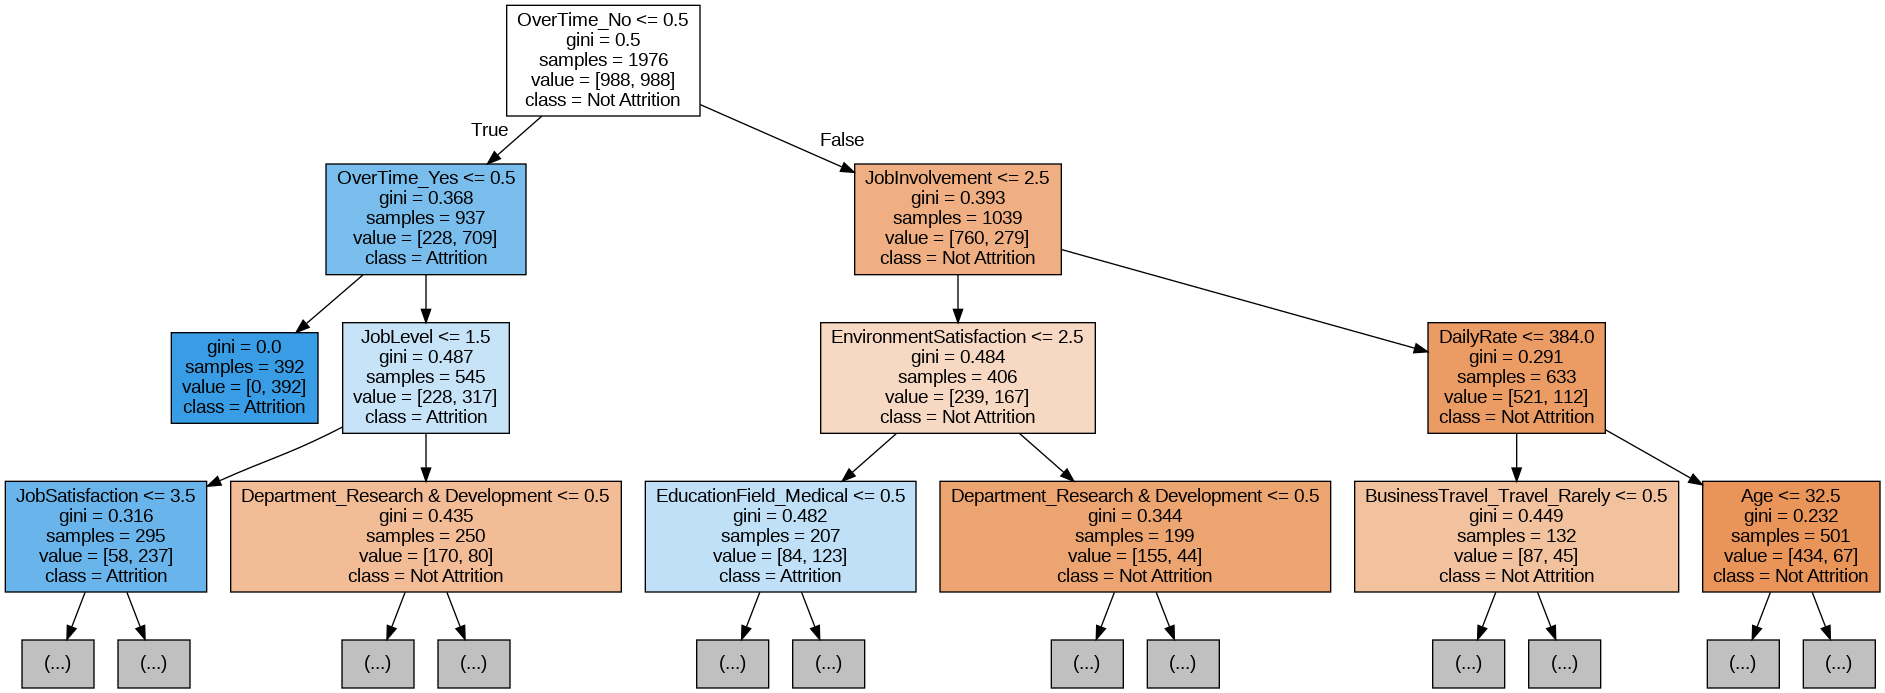

In [ ]:
print(tree_clf.classes_)

class_names = ["Not Attrition", "Attrition"]

# Control the depth of the tree in the visualization
dot_data = StringIO()
export_graphviz(
    tree_clf,
    out_file=dot_data,
    feature_names=features,
    filled=True,
    class_names=class_names,  # Add this to show class labels
    max_depth=3  # Adjust this value to control the depth
)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

In [ ]:


rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    988.0  988.0       1.0     1976.0        1976.0
_______________________________________________
Confusion Matrix: 
 [[988   0]
 [  0 988]]

Test Result:
Accuracy Score: 86.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.872727   0.736842  0.863946    0.804785      0.850080
recall       0.979592   0.285714  0.863946    0.632653      0.863946
f1-score     0.923077   0.411765  0.863946    0.667421      0.837858
support    245.000000  49.000000  0.863946  294.000000    294.000000
_______________________________________________
Conf

In [ ]:



# Save the best XGBoost model
joblib.dump(rf_clf, '/content/drive/MyDrive/Colab Notebooks/models/rf_attrition.joblib')
print("Saved RF model")

Saved RF model


In [ ]:
dataset = attrition
dataset.head()




,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,OverTime,PercentSalaryHike,PerformanceRating,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,Yes,11,3,80,8,0,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,No,23,4,80,10,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,Yes,15,3,80,7,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,Yes,11,3,80,8,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,No,12,3,80,6,3,2,2,2,2


In [ ]:
# Empty list to store columns with categorical data
categorical_dataset = []
for col, value in dataset.items():  # Use items() instead of iteritems()
    if value.dtype == 'object':
        categorical_dataset.append(col)

# Store the numerical columns in a list numerical
numerical_dataset = dataset.columns.difference(categorical_dataset)

# Output the lists for verification
print("Categorical columns:", categorical_dataset)
print("Numerical columns:", numerical_dataset)


Categorical columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numerical columns: Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'StandardHours',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


In [ ]:
# Create a mapping for 'Attrition'
dataset["Attrition"] = dataset["Attrition"].map({'Yes': 1, 'No': 0})

In [ ]:
dataset.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'StandardHours',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [ ]:
# Store the categorical data in a dataframe called attrition_cat
attrition_cat = dataset[categorical_dataset]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column
attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)
# Scale numerical columns if needed
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attrition_num_scaled = pd.DataFrame(scaler.fit_transform(dataset[numerical_dataset]), columns=numerical)


In [ ]:
attrition_num = dataset[numerical_dataset]
dataset_final = pd.concat([attrition_num, attrition_cat, dataset["Attrition"]], axis=1)

In [ ]:
d = dice_ml.Data(dataframe=dataset_final, continuous_features=numerical_dataset.to_list(), outcome_name='Attrition')


In [ ]:




target = attrition_final_labels["Attrition"]
# Split data into train and test
datasetX = attrition_final_labels.drop("Attrition", axis=1)


x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

print(x_train.columns)
print(x_train.head())

# Apply SMOTE to oversample the minority class
sm = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)



numerical = numerical_dataset.to_list()
categorical = x_train_resampled.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train_resampled, y_train_resampled)

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'StandardHours',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_M

<Axes: >

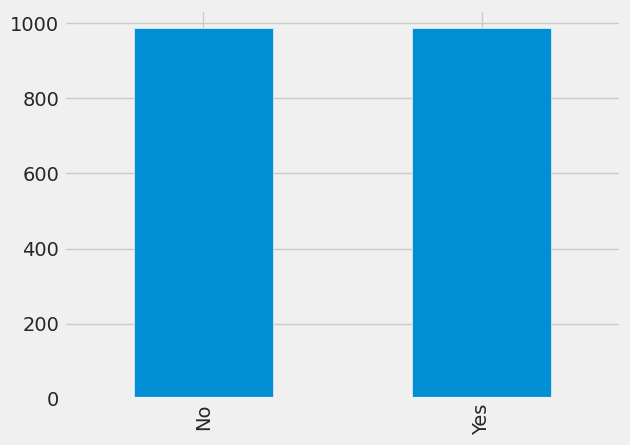

In [ ]:
y_train_resampled.value_counts().plot(kind='bar')


In [ ]:
# provide the trained ML model to DiCE's model object
backend = 'sklearn'
m = dice_ml.Model(model=model, backend=backend)

In [ ]:
exp_random = dice_ml.Dice(d, m, method="random")

In [ ]:
# prompt: predict x_train instances and select those where prediction is 1

# Predict the class for all instances in X_test
predicted_classes = model.predict(x_train)

print(predicted_classes)


# Select instances where the prediction is 1
selected_instances = x_train[predicted_classes == 'Yes']

# Display the selected instances
selected_instances

['No' 'No' 'Yes' ... 'No' 'No' 'Yes']


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
947,52,1030,5,3,2,64,3,3,2,8446,...,0,0,0,1,0,0,0,1,0,1
1273,22,1294,8,1,3,79,3,1,1,2398,...,0,0,0,0,0,0,1,0,0,1
1326,32,414,2,4,3,82,2,2,2,9907,...,0,0,0,1,0,0,0,1,0,1
33,39,895,5,3,4,56,3,2,4,2086,...,0,0,0,0,1,0,1,0,1,0
761,36,660,15,3,1,81,3,2,3,4834,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,37,625,1,4,1,46,2,3,3,10609,...,0,0,0,1,0,0,1,0,1,0
838,42,481,12,3,3,44,3,4,1,13758,...,0,0,0,1,0,0,0,1,0,1
378,34,1362,19,3,1,67,4,2,4,5304,...,0,0,0,1,0,0,0,1,0,1
443,22,1368,4,1,3,99,2,1,3,3894,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
query_instances = selected_instances[0:40]
dice_exp_random = exp_random.generate_counterfactuals(query_instances, total_CFs=3, desired_class="opposite", verbose=False)


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


In [ ]:
dice_exp_random.visualize_as_dataframe(show_only_changes=True)


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,52,1030,5,3,2,64,3,3,2,8446,...,0,0,1,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,3,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,22,1294,8,1,3,79,3,1,1,2398,...,0,0,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,60,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,18292,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,32,414,2,4,3,82,2,2,2,9907,...,0,0,1,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,3,-,-,-,...,-,-,-,-,-,-,-,1,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,39,895,5,3,4,56,3,2,4,2086,...,0,0,0,1,0,1,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,17014,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,1,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,36,660,15,3,1,81,3,2,3,4834,...,0,0,0,0,1,0,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,29,806,7,3,2,39,3,1,3,3339,...,0,0,0,0,1,0,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,4,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,3,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,2,-,-,...,-,-,-,-,-,-,-,1,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,50,869,3,2,1,86,2,1,3,2683,...,0,0,0,1,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,4,-,4,5,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,3,-,-,-,...,1,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,40,1479,24,3,2,100,4,4,2,13194,...,0,0,1,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,4,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,74,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,23,1243,6,3,3,63,4,1,1,1601,...,0,0,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,25,383,9,2,1,68,2,1,1,4400,...,0,0,0,1,0,1,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,40,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,3,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,21,1427,18,1,4,65,3,1,4,2693,...,0,1,0,0,0,0,1,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,29,224,1,4,1,100,2,1,1,2362,...,0,1,0,0,0,0,1,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,4,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,4,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,21,-,4,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,26,920,20,2,4,69,3,1,2,2148,...,0,0,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1,-,No
2,-,-,-,-,-,-,-,2,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,53,1168,24,4,1,66,3,3,1,10448,...,0,0,1,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1,-,No
1,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,1,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,26,1330,21,3,1,37,3,1,3,2377,...,0,0,0,0,1,0,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,61,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,58,286,2,4,4,31,3,5,2,19246,...,1,0,0,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,1,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,1,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,49,1475,28,2,1,97,2,2,1,4284,...,0,0,0,0,0,0,1,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,3,-,-,-,...,-,-,-,-,-,1,-,-,-,No
1,-,-,-,-,-,-,4,-,4,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,1,-,-,-,-,-,-,-,...,-,-,-,-,-,1,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,28,1157,2,4,1,84,1,1,4,3464,...,0,1,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1,-,No
1,40,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,4,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,26,342,2,3,1,57,3,1,1,2042,...,0,1,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,11087,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,14152,...,-,-,-,-,-,-,-,1,-,No
2,-,-,-,-,-,-,-,-,-,15975,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,20,871,6,3,4,66,2,1,4,2926,...,0,0,0,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,18235,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,36,885,16,4,3,43,4,1,1,2743,...,0,0,0,0,0,0,1,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,6347,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,5,-,6797,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,10527,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,35,556,23,2,2,50,2,2,3,5916,...,0,0,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,5,-,-,3,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,4,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,29,408,23,1,4,45,2,3,1,7336,...,0,0,1,0,0,1,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,35,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,89,4,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,4,-,-,-,...,-,-,-,-,1,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,46,1254,10,3,3,64,3,3,2,7314,...,0,0,1,0,0,1,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,1,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,1,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,406,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,35,130,25,4,4,96,3,1,2,2022,...,0,1,0,0,1,0,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,18062,...,-,-,-,-,-,-,-,1,-,No
1,-,-,-,-,-,-,-,-,-,6629,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,12323,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,33,587,10,1,1,38,1,1,4,3408,...,0,0,0,0,1,0,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,20,-,-,-,-,5,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,0,-,-,-,-,No
2,-,-,-,-,-,-,-,5,-,-,...,-,-,-,-,-,1,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,29,428,9,3,2,52,1,1,2,2760,...,0,0,0,1,0,0,1,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,4,-,3,-,...,-,-,-,-,-,-,-,-,-,No
1,-,219,-,-,4,-,4,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,4,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,36,318,9,3,4,79,2,1,3,3388,...,0,1,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,42,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,33,350,5,3,4,34,3,1,3,2851,...,0,0,0,1,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,1,-,1,-,No
1,-,-,23,-,-,-,-,5,-,-,...,-,-,-,-,-,-,-,1,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,0,-,-,-,1,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,51,1323,4,4,1,34,3,1,3,2461,...,0,1,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,1,-,-,-,-,No
1,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,4,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,29,896,18,1,3,86,2,1,4,2389,...,0,1,0,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,46,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,3,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,7131,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,29,408,25,5,3,71,2,1,2,2546,...,0,1,0,0,0,1,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,6632,...,-,-,-,-,-,-,-,-,-,No
1,49,-,-,-,-,-,-,-,-,19747,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,17878,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,40,299,25,4,4,57,2,3,2,9094,...,0,0,1,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1,-,No
1,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,1,-,-,-,No
2,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,39,592,2,3,1,54,2,1,1,3646,...,0,0,0,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,1,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,24,1287,7,3,1,55,3,1,3,2886,...,0,0,0,0,0,1,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,29,121,27,3,2,35,3,3,4,7639,...,0,0,1,0,0,1,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,1,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,32,1045,4,4,4,32,1,3,4,10400,...,0,0,1,0,0,1,0,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,4,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,25,-,-,-,4,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,66,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,26,575,3,1,3,73,3,1,1,3102,...,0,1,0,0,0,0,1,1,0,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,15,-,-,-,-,-,4,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,1,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,42,933,19,3,3,57,4,1,3,2759,...,0,1,0,0,1,0,0,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,4,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
1,-,-,-,-,-,-,-,-,-,10279,...,-,-,-,-,-,-,-,1,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No


Query instance (original outcome : Yes)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,26,950,4,4,4,48,2,2,4,5828,...,0,0,1,0,0,0,1,0,1,Yes



Diverse Counterfactual set (new outcome: No)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,1,-,1,-,No
1,-,-,-,-,2,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,No
